In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/CT_Kidney_dataset"



In [ ]:
import os

classes = os.listdir(dataset_path)
print("Contents:", classes)


Contents: ['Cyst', 'Normal', 'Stone', 'Tumor', 'kidneyData.csv']


In [ ]:
for cls in ['Cyst', 'Normal', 'Stone', 'Tumor']:
    folder = os.path.join(dataset_path, cls)
    count = len([f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    print(f"{cls}: {count} images")


Cyst: 3709 images
Normal: 5077 images
Stone: 1377 images
Tumor: 2283 images


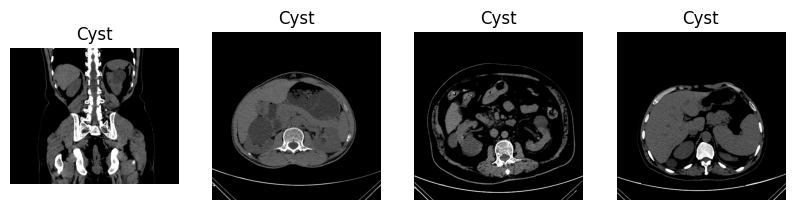

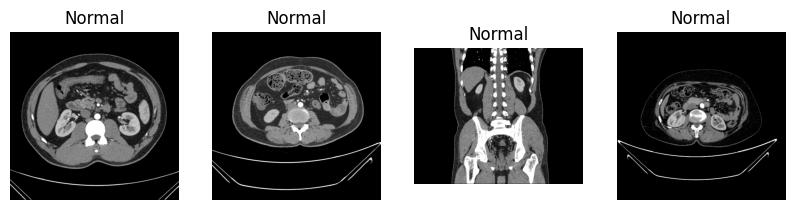

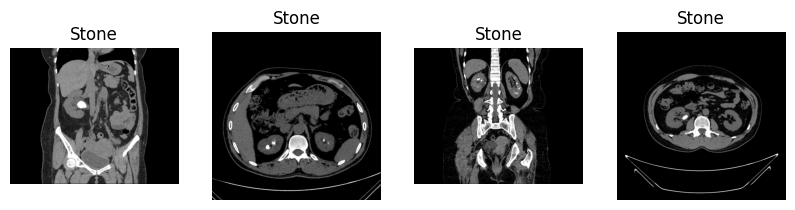

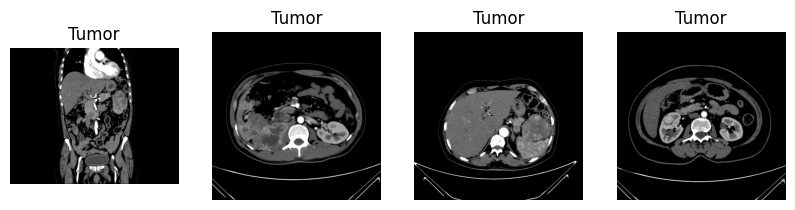

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_samples(class_name, n=4):
    folder = os.path.join(dataset_path, class_name)
    images = random.sample(os.listdir(folder), n)

    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        image_path = os.path.join(folder, img_name)
        img = Image.open(image_path)

        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

show_samples("Cyst")
show_samples("Normal")
show_samples("Stone")
show_samples("Tumor")


In [ ]:
import shutil

small_dataset = "/content/kidney_small_200"
os.makedirs(small_dataset, exist_ok=True)

for cls in ['Cyst', 'Normal', 'Stone', 'Tumor']:
    src_dir = os.path.join(dataset_path, cls)
    dst_dir = os.path.join(small_dataset, cls)
    os.makedirs(dst_dir, exist_ok=True)

    all_images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    selected = random.sample(all_images, min(200, len(all_images)))

    for img in selected:
        shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, img))

print("Copied 200 images from each class.")


Copied 200 images from each class.


In [ ]:
corrupted = []
from PIL import Image

for cls in ['Cyst', 'Normal', 'Stone', 'Tumor']:
    folder = os.path.join(small_dataset, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            corrupted.append(img_path)
            os.remove(img_path)

print("Removed corrupted images:", len(corrupted))


Removed corrupted images: 0


In [ ]:
train_dir = "/content/kidney_small_200/train"
val_dir = "/content/kidney_small_200/val"
test_dir = "/content/kidney_small_200/test"

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)
    for cls in ['Cyst', 'Normal', 'Stone', 'Tumor']:
        os.makedirs(os.path.join(d, cls), exist_ok=True)

for cls in ['Cyst', 'Normal', 'Stone', 'Tumor']:
    src_folder = os.path.join(small_dataset, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    for img in images[:train_split]:
        shutil.copy(os.path.join(src_folder, img), os.path.join(train_dir, cls))

    for img in images[train_split:val_split]:
        shutil.copy(os.path.join(src_folder, img), os.path.join(val_dir, cls))

    for img in images[val_split:]:
        shutil.copy(os.path.join(src_folder, img), os.path.join(test_dir, cls))

print("Dataset split complete!")


Dataset split complete!


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_lightweight_model():
    # Load MobileNetV2 backbone (pretrained on ImageNet)
    base = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    # Freeze base layers (for small dataset)
    base.trainable = False

    # Add custom layers on top
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer (4 classes)
    out = Dense(4, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)

    # Compile with a stable optimizer for small datasets
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_lightweight_model()
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,427,588 (9.26 MB)

 Trainable params: 167,044 (652.52 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1/255.0)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_test_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = val_test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 560 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint("best_lightweight_model.keras", save_best_only=True)
]


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2619 - loss: 2.2909 - val_accuracy: 0.2167 - val_loss: 1.6064 - learning_rate: 1.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3142 - loss: 1.9593 - val_accuracy: 0.2917 - val_loss: 1.4910 - learning_rate: 1.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3652 - loss: 1.7793 - val_accuracy: 0.3750 - val_loss: 1.3926 - learning_rate: 1.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4220 - loss: 1.5401 - val_accuracy: 0.4250 - val_loss: 1.2929 - learning_rate: 1.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4687 - loss: 1.3618 - val_accuracy: 0.4583 - val_loss: 1.2166 - learning_rate: 1.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4911 - loss: 1.2821 - val_accuracy: 0.5083 - val_loss: 1.1549 - learning_rate: 1.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4798 - loss:

In [ ]:
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7735 - loss: 0.5515
Test Accuracy: 73.33%


# Fine-Tuning Code

In [ ]:
# Unfreeze last 10 layers for gentle fine-tuning
for layer in model.layers[-10:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),   # very small LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6800 - loss: 0.8592 - val_accuracy: 0.6583 - val_loss: 0.8203 - learning_rate: 1.0000e-05
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6886 - loss: 0.7929 - val_accuracy: 0.7083 - val_loss: 0.7861 - learning_rate: 1.0000e-05
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6960 - loss: 0.8508 - val_accuracy: 0.7083 - val_loss: 0.7765 - learning_rate: 1.0000e-05
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6406 - loss: 0.8729 - val_accuracy: 0.7167 - val_loss: 0.7764 - learning_rate: 1.0000e-05
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7059 - loss: 0.7672 - val_accuracy: 0.7083 - val_loss: 0.7860 - learning_rate: 1.0000e-05
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6878 - loss: 0.7610 - val_accuracy: 0.6667 - val_loss: 0.7926 - learning_rate: 1.0000e-05
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6769 - loss:

In [ ]:
loss, acc = model.evaluate(test_data)
print(f"Fine-Tuned Test Accuracy: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8198 - loss: 0.5136
Fine-Tuned Test Accuracy: 75.00%


# Full Hyperparameter Tuning Code

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, RMSprop

def build_hypermodel(hp):
    base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)

    # Tune dense units
    units = hp.Choice('units', [64,128,256])
    x = Dense(units, activation='relu')(x)

    # Tune dropout
    drop = hp.Choice('dropout', [0.2,0.3,0.4])
    x = Dropout(drop)(x)

    out = Dense(4, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)

    # Tune optimizer + LR
    opt_choice = hp.Choice('opt', ['adam','rmsprop'])
    lr_choice = hp.Choice('lr', [1e-3,1e-4,1e-5])

    if opt_choice == 'adam':
        opt = Adam(lr_choice)
    else:
        opt = RMSprop(lr_choice)

    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='kidney_tuning'
)

tuner.search(train_data, validation_data=val_data, epochs=10)


Trial 10 Complete [00h 06m 19s]
val_accuracy: 0.8083333373069763

Best val_accuracy So Far: 0.8083333373069763
Total elapsed time: 01h 03m 24s


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,228 (8.93 MB)

 Trainable params: 82,244 (321.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2),
    ModelCheckpoint("best_tuned_model.keras", save_best_only=True)
]

history_best = best_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3092 - loss: 1.7952 - val_accuracy: 0.5667 - val_loss: 1.0898 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.5136 - loss: 1.1299 - val_accuracy: 0.5917 - val_loss: 1.0167 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5891 - loss: 1.0710 - val_accuracy: 0.6583 - val_loss: 0.8844 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6204 - loss: 0.9281 - val_accuracy: 0.6833 - val_loss: 0.8639 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6938 - loss: 0.8005 - val_accuracy: 0.7000 - val_loss: 0.8511 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6930 - loss: 0.7197 - val_accuracy: 0.6583 - val_loss: 0.8543 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6890 - loss: 0.7352 - val_accuracy: 

In [ ]:
loss, acc = best_model.evaluate(test_data)
print(f"Tuned Model Test Accuracy: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8471 - loss: 0.5217
Tuned Model Test Accuracy: 84.17%


In [ ]:
for layer in best_model.layers[-10:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam

best_model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetuned = best_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6475 - loss: 0.9686 - val_accuracy: 0.7917 - val_loss: 0.6846 - learning_rate: 1.0000e-05
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6965 - loss: 0.7539 - val_accuracy: 0.7917 - val_loss: 0.6792 - learning_rate: 1.0000e-05
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7007 - loss: 0.6793 - val_accuracy: 0.7833 - val_loss: 0.6762 - learning_rate: 1.0000e-05
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7272 - loss: 0.7322 - val_accuracy: 0.7917 - val_loss: 0.6784 - learning_rate: 1.0000e-05
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7632 - loss: 0.6558 - val_accuracy: 0.7917 - val_loss: 0.6826 - learning_rate: 1.0000e-05
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7570 - loss: 0.5930 - val_accuracy: 0.7917 - val_loss: 0.6879 - learning_rate: 1.0000e-05
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7794 - loss:

In [ ]:
loss, acc = best_model.evaluate(test_data)
print(f"Fine-Tuned Tuned Model Accuracy: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8694 - loss: 0.4777
Fine-Tuned Tuned Model Accuracy: 85.83%


In [ ]:
model = best_model  # or tuned/fine-tuned model


In [ ]:
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8694 - loss: 0.4777
Test Accuracy: 85.83%
Test Loss: 0.5235


In [ ]:
import numpy as np

pred_probs = model.predict(test_data)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes

class_names = list(test_data.class_indices.keys())


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


<Figure size 600x600 with 0 Axes>

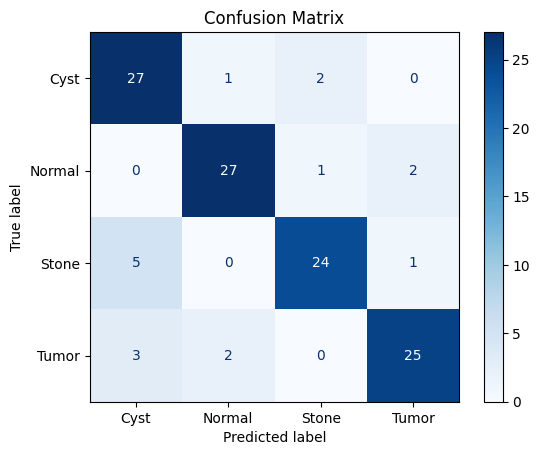

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

        Cyst       0.77      0.90      0.83        30
      Normal       0.90      0.90      0.90        30
       Stone       0.89      0.80      0.84        30
       Tumor       0.89      0.83      0.86        30

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



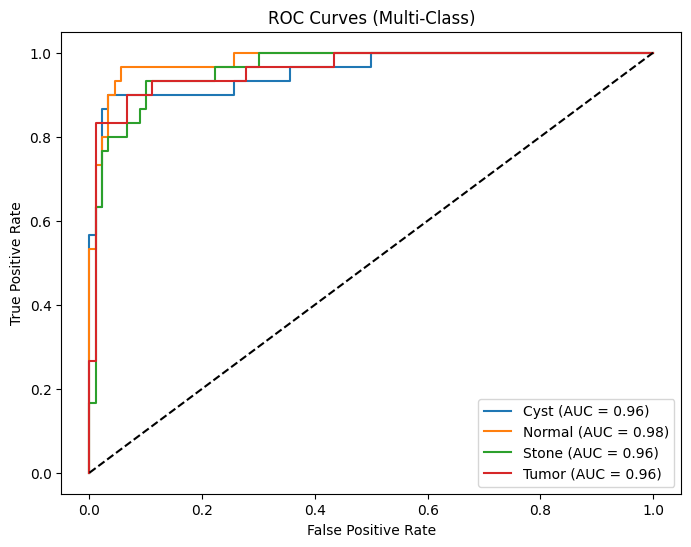

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
plt.figure(figsize=(8,6))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multi-Class)")
plt.legend()
plt.show()


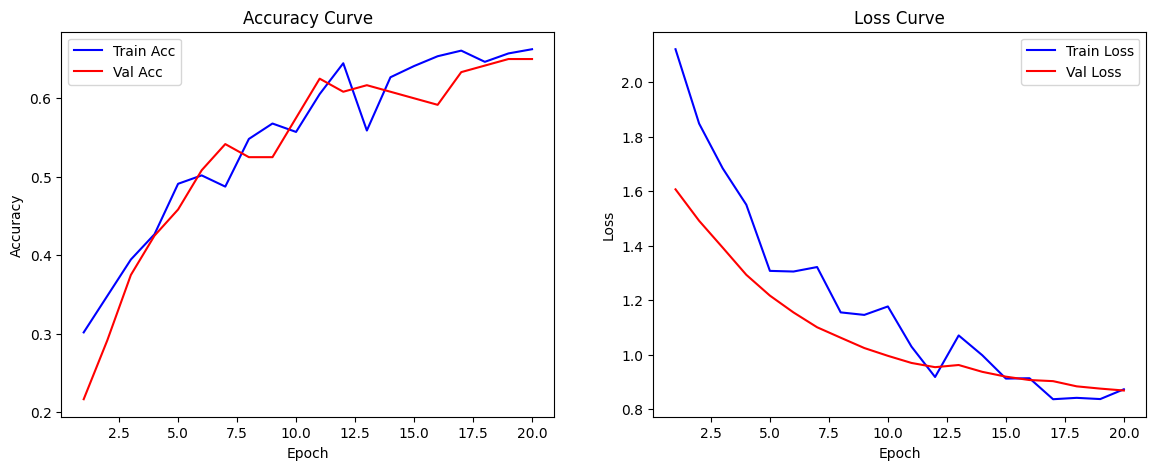

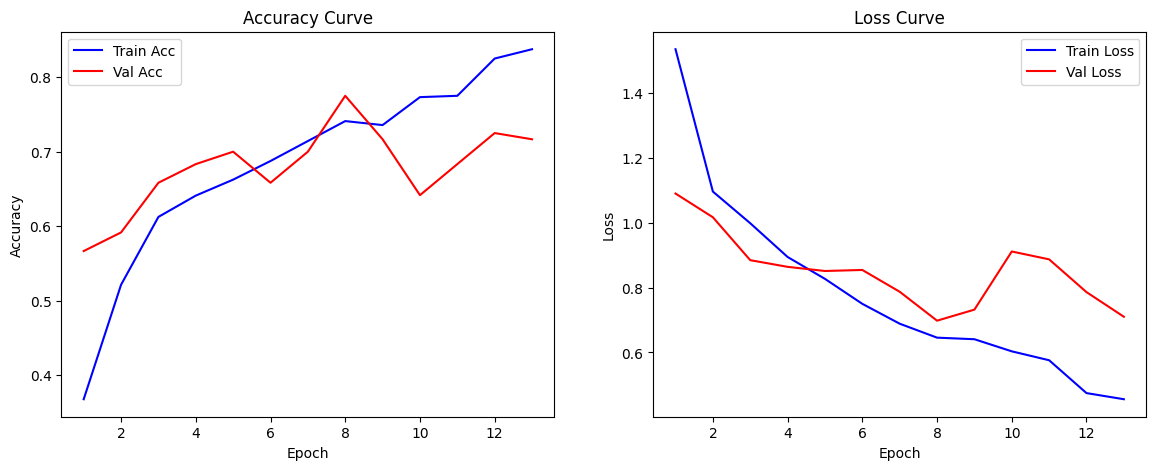

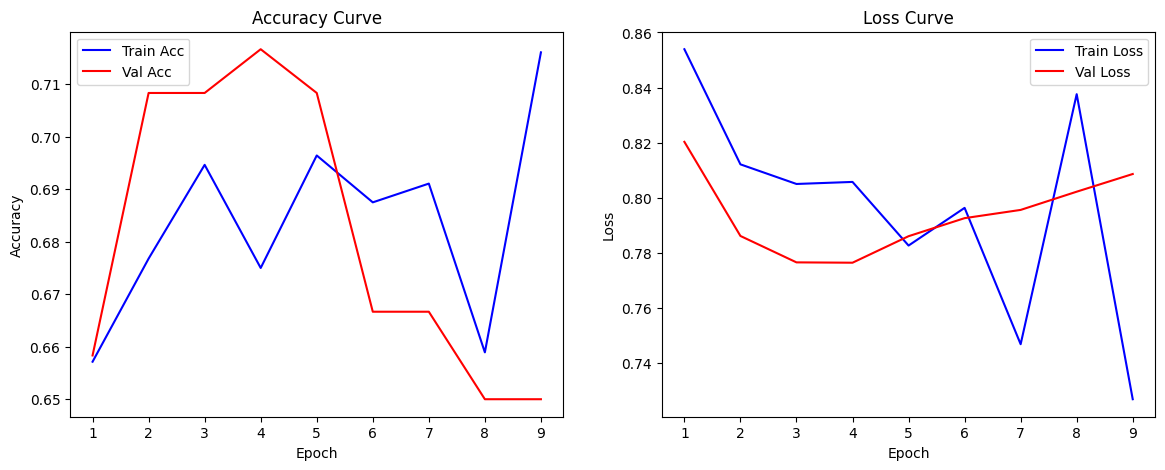

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label="Train Acc")
    plt.plot(epochs, val_acc, 'r-', label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label="Train Loss")
    plt.plot(epochs, val_loss, 'r-', label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Example usage:
plot_history(history)
plot_history(history_best)
plot_history(history_finetune)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_158']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


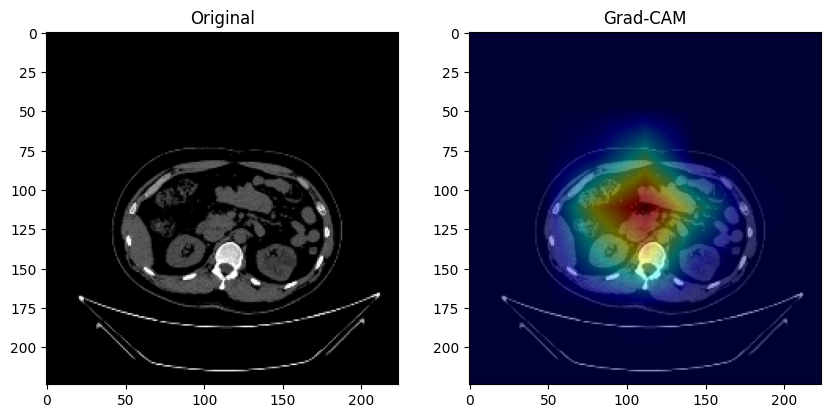

In [ ]:
import tensorflow as tf
import cv2

# Choose an image
img_path = test_data.filepaths[0]

# Load and preprocess
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_input = np.expand_dims(img_array, axis=0)

# Build Grad-CAM model
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer('Conv_1').output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_input)
    class_idx = np.argmax(predictions[0])
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
conv_outputs = conv_outputs[0]

heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Overlay on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)); plt.title("Grad-CAM")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


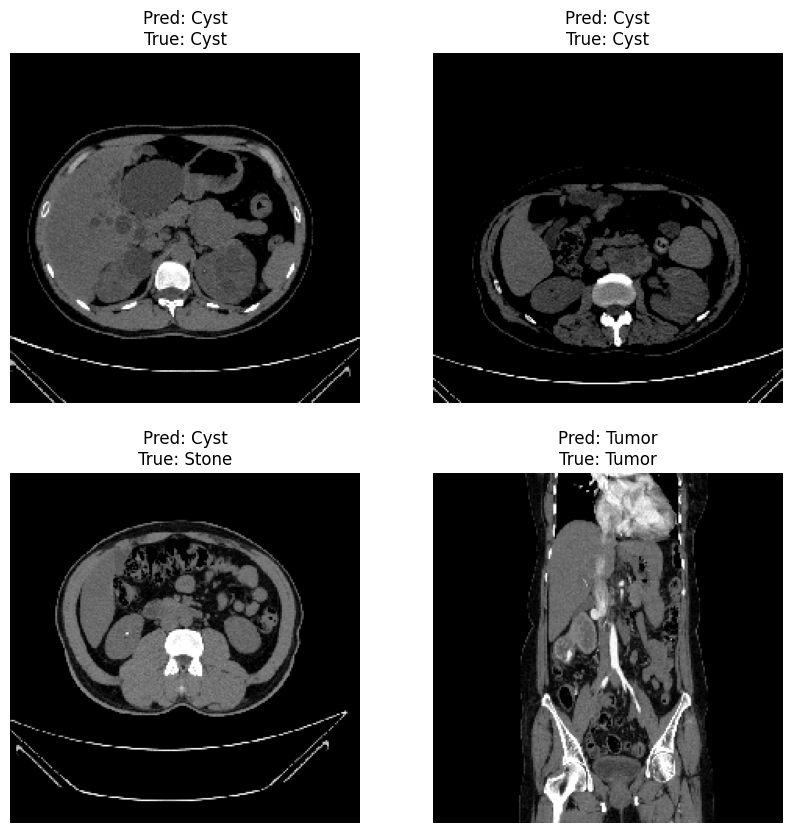

In [ ]:
import random

indexes = random.sample(range(len(test_data.filepaths)), 4)

plt.figure(figsize=(10,10))
for i, idx in enumerate(indexes):
    img_path = test_data.filepaths[idx]

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_arr = tf.keras.preprocessing.image.img_to_array(img)/255.0
    pred = model.predict(np.expand_dims(img_arr, axis=0))
    pred_class = class_names[np.argmax(pred)]
    true_class = class_names[y_true[idx]]

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
    plt.axis('off')

plt.show()
